## Full notebook for running a YOLOv5 training and creating Eigen-CAM visualizations

### Import thesis respository

In [1]:
!git clone https://github.com/ElishaNieuwburg/thesis.git
%cd thesis
%pip install -qr requirements.txt
%cd ..

Cloning into 'thesis'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 156 (delta 0), reused 2 (delta 0), pack-reused 153
Receiving objects: 100% (156/156), 148.13 MiB | 15.72 MiB/s, done.
Resolving deltas: 100% (79/79), done.
Updating files: 100% (20/20), done.
/content/thesis
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.9/157.9 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.0/157.0 kB 

### YOLOv5 import

In [2]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import utils

%cd ..

Cloning into 'yolov5'...
remote: Enumerating objects: 15705, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 15705 (delta 9), reused 14 (delta 4), pack-reused 15672
Receiving objects: 100% (15705/15705), 14.51 MiB | 19.54 MiB/s, done.
Resolving deltas: 100% (10750/10750), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.4/591.4 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 15.7 MB/s eta 0:00:00
/content


### Custom YOLOv5 training

Comment out when you want to train your own YOLOv5 model.
Follow the tutorial of https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data for more information.

In [3]:
## Use this code if your data is located on Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive')
# display = utils.notebook_init()

In [4]:
## Change data path to path where yaml file is located
# !python yolov5/train.py --batch-size 64 --epochs 1 --data '/content/gdrive//MyDrive/data/DamageNT/damage.yaml' --weights 'yolov5/yolov5s.pt' --hyp 'yolov5/data/hyps/hyp.no-augmentation.yaml'

In [5]:
## Automatically uses best weights obtained from training in previous cell
## Also change here data to own data path!
# !python yolov5/val.py --weights yolov5/runs/train/exp/weights/best.pt --data '/content/gdrive//MyDrive/data/DamageNT/damage.yaml' --task test

### YOLOv5 inference

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.10.11 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


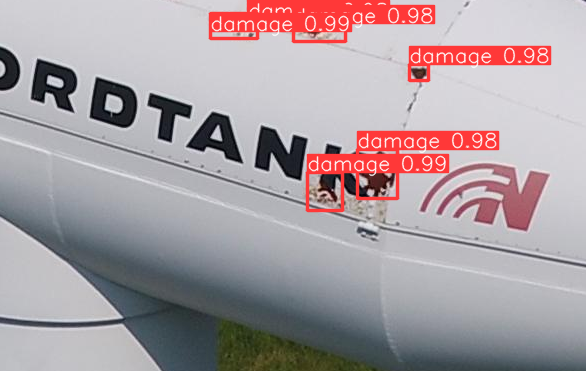

In [6]:
# You can use the pretrained weights from the repository, or weights from own training
# Test images are provided in data folder
model = torch.hub.load('ultralytics/yolov5', 'custom', path='thesis/weights/yolov5s.pt')
img = "thesis/data/images/test_img_1.png"
results = model(img)
results.show()

## Eigen-CAM visualizations
#### Code based on the tutorial of https://jacobgil.github.io/pytorch-gradcam-book/EigenCAM%20for%20YOLO5.html

In [7]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38241 sha256=950c7a1c43a65a53b62e0aa38558290c05f5e6fecf8b58eafe83e3034c0e2f48
  Stored in directory: /root/.cache/pip/wheels/3c/6c/04/9a543775e9f25f6c441180a552456f1696167439459730ff87
Successfully built grad-cam


In [8]:
"""
CODE TAKEN FROM https://jacobgil.github.io/pytorch-gradcam-book/EigenCAM%20for%20YOLO5.html
"""
import os
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

# Get the YOLOv5 detections
def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


# Draw detections on the image
def draw_detections(boxes, colors, img):
    for box, color in zip(boxes, colors):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 2)

    return img

def renormalize_cam_in_bounding_boxes(boxes, colors, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, eigencam_image_renormalized)
    return image_with_bounding_boxes

### Helper functions

In [9]:
from collections import defaultdict

# Change the YOLO format boxes to VOC format
def yolo_to_voc(boxes, size):
    non_centred_box = boxes[:, :2] - 0.5 * boxes[:, 2:]
    boxes = np.concatenate((non_centred_box, non_centred_box + boxes[:, 2:]), axis=1)
    boxes[:, [0, 2]] *= size[0]
    boxes[:, [1, 3]] *= size[1]

    # Scale boxes to width and height of image
    boxes[boxes < 0] = 0
    boxes[:, 0][boxes[:, 0] > size[0]] = size[0]
    boxes[:, 1][boxes[:, 1] > size[1]] = size[1]
    boxes[:, 2][boxes[:, 2] > size[0]] = size[0]
    boxes[:, 3][boxes[:, 3] > size[1]] = size[1]

    return boxes


# Compute the Intersection over Union score between two boxes
def iou(gt_box, pred_box):
    area =  max(0, min(gt_box[2], pred_box[2]) - max(gt_box[0], pred_box[0]) + 1) * \
            max(0, min(gt_box[3], pred_box[3]) - max(gt_box[1], pred_box[1]) + 1)

    gt_area = (gt_box[2] - gt_box[0] + 1) * (gt_box[3] - gt_box[1] + 1)
    pred_area = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)

    return area / float(gt_area + pred_area - area)

# Crop the image given a certain scale
def crop_img(img, scale):
    w, h = img.size
    new_w = w / scale
    new_h = h / scale
    left = (w - new_w) / scale
    right = new_w + (w - new_w) / scale
    top = (h - new_h) / scale
    bottom = new_h + (h - new_h) / scale

    return img.crop((left, top, right, bottom))


# Resize a bounding box given a new size of the image
def resize_box(boxes, size_new, size_old):
    x_scale = size_new[0] / size_old[0]
    y_scale = size_new[1] / size_old[1]
    
    left = int(boxes[:, 0] * x_scale)
    top = int(boxes[:, 1] * y_scale)
    right = int(boxes[:, 2] * x_scale)
    bottom = int(boxes[:, 3] * y_scale)
    
    return left, top, right, bottom


# Blacken an image around a bounding box area
def black_img(img, box):
    img[:, :box[0]] = 0
    img[:box[1], :] = 0
    img[:, box[2]:] = 0
    img[box[3]:, :] = 0
    
    return img

# Compute false positives and false negatives
def get_fp_fn(boxes, gt_boxes, colors):
    matches = defaultdict(list)
    fp = len(boxes)
    fn = len(gt_boxes)
    for i, box in enumerate(gt_boxes):
        for j, pred_box in enumerate(boxes):
            if iou(box, pred_box) > 0.45:
                matches[i] = pred_box
                fp -= 1
                fn -= 1
                colors[j] = (0, 255, 0)

    return fp, fn, matches, colors

In [10]:
# Create the Eigen-CAM visualizations
def create_vis(array_img, img_name, label_path):
    # Prepare image
    img = cv2.resize(array_img, (640, 640))
    rgb_img = img.copy()
    img = np.float32(img) / 255
    transform = transforms.ToTensor()
    tensor = transform(img).unsqueeze(0)
    
    # Get detections on image
    results = model([rgb_img.copy()])
    boxes, colors, names = parse_detections(results)  # Boxes are xmin, ymin, xmax, ymax, (not normalized) confidence, class, name
    colors = [(255, 0, 0) for _ in range(len(boxes))]
    
    try:
        f = open(os.path.join(label_path, img_name[:-4] + '.txt'), 'r')
        data = np.array([line.strip().split(" ") for line in f.readlines()]).astype(float)
        f.close()
    except OSError:
        gt_boxes = []
        detections = rgb_img.copy()
    else:
        gt_boxes = yolo_to_voc(data[:, 1:], (img.shape[1], img.shape[0]))
        detections = draw_detections(gt_boxes, [(0, 0, 255) for _ in range(len(gt_boxes))], rgb_img.copy())

    # If you want to know what the false positives, true positives are
    _, _, _, colors = get_fp_fn(boxes, gt_boxes, colors)
    
    cam = EigenCAM(model, target_layers, use_cuda=False)
    grayscale_cam = cam(tensor)[0, :, :]
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    drawn_cam_image = draw_detections(boxes, colors, cam_image.copy())
    renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, img, grayscale_cam)
    im = Image.fromarray(np.hstack((cv2.resize(detections, (586, 371)), cv2.resize(cam_image, (586, 371)), cv2.resize(renormalized_cam_image, (586, 371)))))
        
    return im

In [11]:
# File paths, change to custom data paths if necessary
imgs_path = 'thesis/data/images'
label_path = 'thesis/data/labels'
weights_path = 'thesis/weights/yolov5s.pt'

In [12]:
# Load the model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path)
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.10.11 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


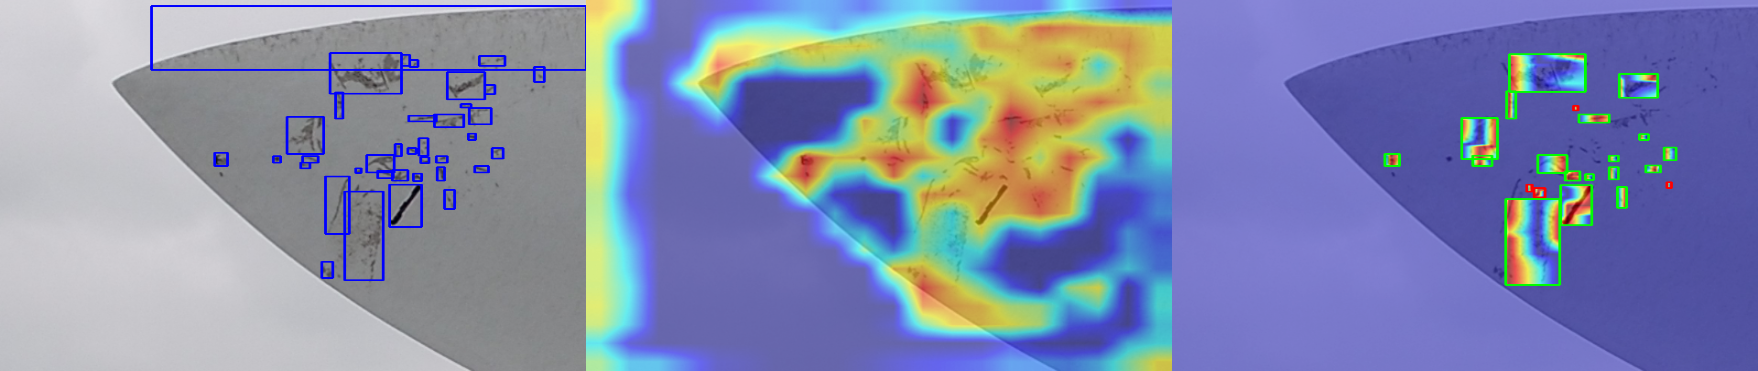

In [13]:
# Run on a test image and save
img_name =  'test_img_2.png'
output_name = 'test_img_cam.png'
img = np.array(Image.open(os.path.join(imgs_path, img_name)))
cam_im = create_vis(img, img_name, label_path)
cam_im